# HW 3 - Synonym Detection In Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning. This is similar to the intuition behind the word2vec algorithm.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrance matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __identify__ when it makes sense to take a stripe approach and when to use pairs
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 

__RECOMMENDED READING FOR HW3__:	
Your reading assignment for weeks 4 and 5 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings, especially when it comes to the similarity formulas -- they are directly relevant to this assignment.

DITP Chapter 4 - Inverted Indexing for Text Retrieval. While this text is specific to Hadoop, the Map/Reduce concepts still apply.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [7]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [9]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

21/10/04 23:48:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [10]:
# Spark configuration Information (RUN THIS CELL AS IS)
sc.getConf().getAll()

[('spark.app.id', 'local-1633391311837'),
 ('spark.app.name', 'hw3_notebook'),
 ('spark.driver.port', '33129'),
 ('spark.sql.warehouse.dir',
  'file:/home/ls_enel/Assignments/HW3/docker/student/spark-warehouse'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.driver.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.startTime', '1633391310366')]

In [11]:
# get Spark Session info (RUN THIS CELL AS IS)
spark

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Answer each one very briefly - 2 to 3 sentences.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how does it relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

### Q1 Student Answers:
> __a)__ Spark is an computing framework that is used to process large scale data. It is open source and has useful APIs for programming in Scala, Python, and Java. Similar to Hadoop's MapReduce framework, Spark reads and processes data using transformations (similar to Maps) and actions (similar to reduce) but has improved performance due to caching.

> __b)__ Spark observes many properties of functional programming in that it does not modify data but instead always creates new structures and follows a 'lazy' programming design by which nothing will execute until you need the data. It differs from purefly functional programing as Spark allows side effects, meaining changes in state depend on the functions inputs.  

> __c)__ A 'DAG' is a Directed Acyclic Graph. 'Transformations' are like maps in that they are functions that are applied to each record in a RDDs (resilient distributed dataset) to output results to a new RDDS. An 'action' is a result oriented function that outputs values. The DAG has the lists of transformations that will occur but again follow a 'lazy' programmign design in that they will only execute when the data is needed. 



# Question 2: Similarity Metrics
As mentioned in the introduction to this assignment, an intuitive way to compare the meaning of two documents is to compare the list of words they contain. Given a vocabulary \\(V\\) (feature set) we would represent each document as a vector of `1`-s and `0`-s based on whether or not it contains each word in \\(V\\). These "one-hot encoded" vector representations allow us to use math to identify similar documents. However like many NLP tasks the high-dimensionality of the feature space is a challenge... especially when we start to scale up the size and number of documents we want to compare.

In this question we'll look at a toy example of document similarity analysis. Consider these 3 'documents': 
```
docA	the flight of a bumblebee
docB	the length of a flight
docC	buzzing bumblebee flight
```
These documents have a total of \\(7\\) unique words: 
>`a, bumblebee, buzzing, flight, length, of, the`.     

Given this vocabulary, the documents' vector representations are (note that one-hot encoded entries follow the order of the vocab list above):

```
docA	[1,1,0,1,0,1,1]
docB	[1,0,0,1,1,1,1]
docC	[0,1,1,1,0,0,0]
```  

### Q2 Tasks:

* __a) short response:__ The cosine similarity between two vectors is $$\frac{A\cdot B}{\|A\|\|B\|}$$. Explain what the the numerator and denominator of this calculation would represent in terms of word counts in documents A and B. 

* __b) short response:__ Explain how the Jaccard, Overlap and Dice metrics are similar/different to the calculation for cosine similarity. When would these metrics lead to different similarity rankings for a set of documents? HINT: consider documents of very different lengths. It may be helpful to generate some small examples.

* __c) short response:__ Calculate the cosine similarity for each pair of documents in our toy corpus. Please use markdown and \\(\LaTeX\\) to show your calcuations.  

* __d) short response:__ According to your calculations in `part c` which pair of documents are most similar in meaning? __BONUS__: Does this match your expecatation from reading the documents? If not, speculate about why we might have gotten this result.

* __e) short response:__ In NLP common words like '`the`', '`of`', and '`a`' increase our feature space without adding a lot of signal about _semantic meaning_. Repeat your analysis from `part c` but this time ignore these three words in your calculations [__`TIP:`__ _to 'remove' stopwords just ignore the vector entries in columns corresponding to the words you wish to disregard_]. How do your results change?

### Q2 Student Answers:
> __a)__ The dot product of two document vectores (i.e. the numerator) represents how strongly aligned two document vectors are (e.g. do they share a lot of words in common). The denomenator represents the product of the magnitude of the two document vectors to help normalize for the size of a given document. Without this normalization step, longer documents would have more opportunity to contain most of the dictionary words and could have a stronger similarity score. 

> __b)__ 

- Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets. Jaccard similarity takes only unique set of words for each sentence / document while cosine similarity takes total length of the vectors so repeat words impact cosine similarity but not jaccard. Jaccard similarity is good for cases where duplication does not matter, cosine similarity is good for cases where duplication matters while analyzing text similarity.

- Dice metric is more intuitive because it can be seen as the percentage of overlap between the two sets. Dice checks for existence (set intersection), while cosine checks for a metric (scalar product). If a word is repeated multiple times, the cosine similarity will change but the dice will not.

- Overlap represents the percentage of overlap normalized by the smaller document size. The overlap similarity can help determine which document are subsets of others, which could be useful for determing relationships such as in the field of taxonomy. 


> __c)__ 

Cosine similarity score of A-B $$= \frac{[1,1,0,1,0,1,1]^T\cdot[1,0,0,1,1,1,1]}{|[1,1,0,1,0,1,1]|*|[1,0,0,1,1,1,1]|} = \frac{1*1 + 1*0 +0*0 + 1*1 + 0*1 + 1*1 +1*1}{\sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2}\sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2}} = \frac{4}{\sqrt{5*5}} = 0.80$$

Cosine similarity score of A-C $$= \frac{[1,1,0,1,0,1,1]^T\cdot[0,1,1,1,0,0,0]}{|[1,1,0,1,0,1,1]|*|[0,1,1,1,0,0,0]|} = \frac{1*0 + 1*1 +0*1 + 1*1 + 0*0 + 1*0 +1*0}{\sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2}\sqrt{0^2+1^2+1^2+1^2+0^2+0^2+0^2}} = \frac{2}{\sqrt{5*3}} \approx 0.52$$

Cosine similarity score of B-C $$= \frac{[1,0,0,1,1,1,1]^T\cdot[0,1,1,1,0,0,0]}{|[1,0,0,1,1,1,1]|*|[0,1,1,1,0,0,0]|} = \frac{1*0 + 0*1 +0*1 + 1*1 + 1*0 + 1*0 +1*0}{\sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2}\sqrt{0^2+1^2+1^2+1^2+0^2+0^2+0^2}} = \frac{1}{\sqrt{5*3}} \approx 0.26$$



> __d)__ Documents A and B are the most similar.     
> __d-bonus)__ Intuitively it does because 5/7 of the entries for A and B are identical whereas the other pairs are mostly dissimilar. So even though the normalizer magnitude of Doc C is smaller, it still cannot overcome the dissimilarity in word apperances. One might intuitively think that C and A should be the most similar given 2/3 of the words in C are captured in A but the differences in size of the documents contribute top their dissimilarity.

> __e)__ new word vector = [a, bumblebee, buzzing, flight, length, of, the]

A' = [1,0,1,0], B' = [0,0,1,1], c' = [1,1,1,0]

Cosine similarity score of A-B udpated $$= \frac{[1,0,1,0]^T\cdot[0,0,1,1]}{|[1,0,1,0]|*|[0,0,1,1]|} = \frac{1*0 + 0*0 +1*1 + 0*1}{\sqrt{1^2+0^2+1^2+0^2}\sqrt{0^2+0^2+1^2+1^2}} = \frac{1}{\sqrt{2*2}} = 0.25$$

Cosine similarity score of A-C updated $$= \frac{[1,0,1,0]^T\cdot[1,1,1,0]}{|[1,0,1,0]|*|[1,1,1,0]|} = \frac{1*1 +0*1 + 1*1 + 0*0}{\sqrt{1^2+0^2+1^2+0^2}\sqrt{1^2+1^2+1^2+0^2}} = \frac{2}{\sqrt{2*3}} \approx 0.82$$

Cosine similarity score of B-C updated $$= \frac{[0,0,1,1]^T\cdot[1,1,1,0]}{|[0,0,1,1]|*|[1,1,1,0]|} = \frac{0*1 +0*1 + 1*1 + 1*0}{\sqrt{0^2+0^2+1^2+1^2}\sqrt{1^2+1^2+1^2+0^2}} = \frac{1}{\sqrt{2*3}} \approx 0.41$$


With these updated results, we find that documents A-C are the most similar. 

# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrance comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [12]:
# (RUN THIS CELL AS IS)
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [13]:
# (RUN THIS CELL AS IS)
words = list(set(re.findall(r'\w+', corpus.lower())))
print(words)

['worst', 'of', 'best', 'foolishness', 'was', 'the', 'times', 'age', 'wisdom', 'it']


But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [14]:
# (RUN THIS CELL AS IS)
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [15]:
# (RUN THIS CELL AS IS)
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


Your goal in the tasks below is to asses, which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) short response:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? More generally for a n-word vocabulary how many pairwise comparisons are there to make? 

* __b) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ (two words on either side) of the `term`'s position in the original text (In this exercise, use ['it', 'was', 'the','of'] as stopwords, just ignore them from your 5 word vectors).

* __c) short response:__ Run the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeros? 

* __d) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __e) short response:__ Which pairs of words have the highest 'similarity' scores? __BONUS__: Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:
> __a)__ we will compare 6!/(2*4!) pairs words for this vocabulary (i.e. age-best + age-foolishness + ... wisdom-worst) = 15 pairs. Generally for an n-word vocavulary, this is C(n,2) = n! / (2! (n – 2)!).

> __c)__ Of the 36 entries, 28 are zero entries.    

> __e)__ best-worst and foolishness-wisdom have the hightest similarity scores  
__e-bonus)__ These words are antonyms but are commonly occuring in similar documents/sentence structures. Even though these words are not similalr in that they are synonyms, the often occur in the same types of sentences. In a much larger corpous, there are much more opportunities for synonyms to occur rather than antonyms so their similarity scores will not be as high.  

In [16]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness
VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/best-of-times.png?raw=true' style='width:80%'>

In [442]:
# part b - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
# Stopwords: 
#     ['it', 'was', 'the', 'of'] 
# Hint:
#     In provided sentence, age appears in two 5 word vectors: ['was', 'the', 'age', 'of', 'wisdom'] and ['was', 'the', 'age', 'of', 'foolishness']
#     After removing stopwords, the remaining words are 'wisdom' and 'foolishness'
#
#     You finish the rest of the non-stopwords below. 

stripes = {'age':['wisdom', 'foolishness'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best','worst'],
           'wisdom':['age', 'foolishness'],
           'worst':['times']}

# # Comparison for Q8 - TODO Comment out
# stripes = {'age':['times', 'wisdom','foolishness'], # example
#            'best':['times'], # YOU FILL IN THE REST
#            'foolishness':['age'],
#            'times': ['age', 'best','worst'],
#            'wisdom':['age'],
#            'worst':['times']}

In [443]:
# part c - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [444]:
# part c - this cell 1-hot encodes the co-occurrence matrix (RUN THIS CELL AS IS) 
for term, nbrs in stripes.items():
    pass
    for nbr in nbrs:
        co_matrix.loc[term, nbr] = 1
co_matrix

,age,best,foolishness,times,wisdom,worst
age,0,0,1,0,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,0,1,0,0,0,1
wisdom,1,0,1,0,0,0
worst,0,0,0,1,0,0


In [445]:
# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    
    # cosine similarity
    ############# YOUR CODE HERE #################
    csim = np.dot(v1, v2, out=None)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    
    ############# (END) YOUR CODE #################    
    
    print(f"{term1}-{term2}: {csim}")

age-best: 0.0
age-foolishness: 0.4999999999999999
age-times: 0.0
age-wisdom: 0.0
age-worst: 0.0
best-foolishness: 0.0
best-times: 0.0
best-wisdom: 0.0
best-worst: 1.0
foolishness-times: 0.0
foolishness-wisdom: 0.7071067811865475
foolishness-worst: 0.0
times-wisdom: 0.0
times-worst: 0.0
wisdom-worst: 0.0


# Question 4: Pairs and Stripes at Scale

As you read in the paper by Zadeh et al, the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO implemetation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revist the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) short response:__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. In the asynch videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __b) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __c) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. In your own words, define each of these terms ('postings' and 'inverted index') based on your reading of the provided code. (*DITP by Lin and Dyer also contains a chapter on the Inverted Index although in the context of Hadoop rather than Spark. You may find the illustration in Chaprter 4 helpful in answering this question*).

* __d) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __e) short response:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations. Explain.

### Q4 Student Answers:

> __a)__ The stripes approach is advantageous over pairs (i.e. the vector representation in question3) as 1. they can make better use of combiners and 2. far less shuffling and sorting

> __b)__ _read provided code before answering d-f_ 

> __c)__ The "posting" is the output of a mapper that provides a key for each non-unique word and an associated value for where that key was generated from. The inverted index is the flattened/reduced list of documents and document lengths where that key is found, which then provides all the necessary mathematical components for later mapper/reducers to calculate the similiarity score (e.g. doc lengths, words in common) 

> __d)__ It emits pairs of documents that share a key (i.e. a word) in common along with an incremental counter to be summed in a reducer to determine the amount of words two documents share. The original key from the previous reducer is dropped at this stage as it is no longer useful since we now have a way to count how many words to documents have in common. The commposite key also contains each documents length which is needed in the similiarity scores (e.g. the magnitude of the doc vector in the cosine similarity)  

> __e)__ The narrow transformations include "splitWords" and "makeCompositeKey" as these take wide inputs (e.g. a document/Ngram for splitwords and the inverted index for makeCompositeKey) and produce compact key-value pairs. Conversely, the first reduce by key is a wide transformation as it takes a narrow two column vector and transforms it into a flatter, much wider vector where information is captured in the value's in the keys instead of across multiple instances of the same key   

A small test file: __`sample_docs.txt`__

In [24]:
%%writefile sample_docs.txt
docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly

Overwriting sample_docs.txt


In [25]:
# load data - RUN THIS CELL AS IS
!cat sample_docs.txt

docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly


__Document Similarity Analysis in Spark:__

In [26]:
# load data - RUN THIS CELL AS IS
data = sc.textFile("sample_docs.txt")  

In [27]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [28]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [29]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

In [30]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
#              .collect()

result

# Flat Map (Split Words):
# Provides a list of key-values where the keys are the non-unique words and 
# the values are the values are tupple with the document ID and the words in that document ID
# [('bright', [('docA', 4)]),
# ('blue', [('docA', 4)]),

# Reduce By Key:
# Aggregates the keys such that the values now are a list of tuples with doc IDS and doc lengs 
# ([('docA', 4), ('docB', 4), ('docC', 4)]

# Flat Map(makeCompositeKey):
# Make a table with the number of co occurences between doc IDS with counters of 1
# [("(('docA', 4), ('docB', 4))", 1),
#  ("(('docA', 4), ('docC', 4))", 1),

# Reduce By Key(jaccard):
# Aggregate the table so the counters are aggregated
# [("(('docA', 4), ('docB', 4))", 2),

# Flat Map:
# Calculate the Jacard Similartiy scores for each unique Doc ID pair
# ('docA - docB', 0.3333333333333333)

#.takeOrdered(10)
# Sort the records from greatest to lowest score


[('docA - docE', 0.75),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: "Synonym" Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available in the 'data' folder in 'Assignments/HW3/' github.  Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms.

In [31]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS = '../../data'
F1_PATH = '../../data/googlebooks-eng-all-5gram-20090715-0-filtered.txt'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [32]:
%%writefile systems_test.txt
it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1

Overwriting systems_test.txt


Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [33]:
# Spark RDDs for each dataset
testRDD = sc.textFile("systems_test.txt") 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peek at what each of these RDDs looks like:

In [34]:
testRDD.take(10)

['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [35]:
f1RDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

In [36]:
dataRDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark application to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances (count) of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._


* __b) short response:__ Given the vocab size you found in part a, how many potential synonym pairs could we form from this corpus? If each term's stripe were 1000 words long, how many tuples would we need to shuffle in order to form the inverted indices? Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __c) short response:__ Looking at the most frequent words and their counts, how usefull will these top words be in synonym detection? Explain.

* __d) short response:__ Looking at the least frequent words and their counts, how reliable should we expect the detected 'synonyms' for these words to be? Explain.

### Q5 Student Answers:

> __b)__ The number of paired combinations is equal to n! / (2! (n – 2)!) = 269339! / (2*(269339 - 2)!) = 269339*269338/2 = 36,271,613,791 potential synonym pairs. The advantage of a stripe over a co-occurence matrix is that it requires far less shuffling/sorting. Given this, we'd have to shuffle n key-value pairs = 269339 for the full dataset.

> __c)__ The top 10 words are: 'the', 'of', 'to', 'in', 'a', 'and', 'that', 'is', 'be', and 'as'. These words are not very special (i.e. should be considered Stopwords) and will show increased similarity in documents that may not be topically all that similar as we saw in part c vs part e of question 2. 

> __d)__ the bottom 10 words are: 'schwetzingen', 'cras', 'parcival', 'porti', 'scribbler's', 'washermen', 'viscerating', 'mildes', 'scholared', 'jaworski'. Given how specialized and infrequently these words occur, the assosciates synonyms are likely not that useful as they are likely gramatically assosciated with these words from the original document rather than true synonyms. 



In [324]:
# part a - write your spark job here 
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############
    
    data = rdd.map(lambda line: line.split('\t')) \
             .map(lambda text_count: (text_count[0].split(" "), text_count[1])) \
             .flatMap(lambda row: [(i.lower(), int(row[1])) for i in row[0]])\
             .reduceByKey(lambda x,y : x+y).cache() 

    top_n = data.takeOrdered(n, key=lambda x: -x[1])
        
    bottom_n = data.takeOrdered(n, key=lambda x: x[1])

    total = len(data.collect())
    
    
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [38]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
import time
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


Wall time: 0.45024561882019043 seconds


In [39]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness          1 |            the  17


Expected output for testRDD:
<pre>
    Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness       1 |            the  17  
</pre>

In [40]:
# part a - run a single file, ie., a small sample (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


Wall time: 1.6464643478393555 seconds


In [41]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40


Expected output for f1RDD
<pre>
Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40
</pre>

In [42]:
# part a - run full analysis (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 369.26355481147766 seconds

Wall time: 150.90080785751343 seconds


In [43]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |     foretastes  40
      of 3698583299 |       parcival  40
      to 2227866570 |   schwetzingen  40
      in 1421312776 |           cras  40
       a 1361123022 |      scholared  40
     and 1149577477 |    scribbler's  40
    that  802921147 |      washermen  40
      is  758328796 |    viscerating  40
      be  688707130 |    unmurmuring  40
      as  492170314 |         mildes  40


Expected output for dataRDD:
(bottom words might vary a little due to ties)
<pre>
Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |   schwetzingen  40
      of 3698583299 |           cras  40
      to 2227866570 |       parcival  40
      in 1421312776 |          porti  40
       a 1361123022 |    scribbler's  40
     and 1149577477 |      washermen  40
    that  802921147 |    viscerating  40
      is  758328796 |         mildes  40
      be  688707130 |      scholared  40
      as  492170314 |       jaworski  40
</pre>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  
 <pre>
  HINT: consider all words within a five-gram to be co-occuring. In other words, a word in a single 5-gram will always have 4 neighbors
  EXAMPLE:
    the dog ate cat litter 
    the cat has clean litter 
    
    Vocabulary:
    the, dog, ate, litter, cat, has, clean
    
    Neighbors:
    (the, dog) (the, ate) (the, cat) (the, littler), (dog, ate) (dog, cat) (dog, litter), (ate, cat) (ate, litter), (cat, litter)
    (the, cat) (the, has) (the, clean) (the, litter), (cat, has) (cat, clean) (cat, litter), (has, clean) (has, litter) (clean, litter)
    
    Unique neighbors:
    the 6
    dog 4
    ate 4
    litter 6
    cat 6
    has 4
    clean 4
 </pre>
    
    
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts     
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.


* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + short response:__ Write a Spark Job to compare word frequencies to number of neighbors.
    * Of the 1000 words with most neighbors, what percent are also in the list of 1000 most frequent words?
    * Of the 1000 words with least neighbors, what percent are also in the list of 1000 least frequent words?   
[__`NOTE:`__ _technically these lists are short enough to compare in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ skewed distribution where some are really popular and some that are less common with a long tail of rare words. There are also a few words (left) with co occuring. 

> __c)__ 88% and 1.2%

In [44]:
def splitWords2(line):
    """Mapper 2: tokenize each document and emit postings."""
#     text, count, pages_count, books_count
    text, count = line[0], line[1]

    words = list(np.unique(np.array(text.split(" "))))
    for i, w in enumerate(words):
        try: w_m4 = words[i-4].lower()
        except: w_m4 = None
        try: w_m3 = words[i-3].lower()
        except: w_m3 = None
        try: w_m2 = words[i-2].lower()
        except: w_m2 = None
        try: w_m1 = words[i-1].lower()
        except: w_m1 = None
        try: w_p1 = words[i+1].lower()
        except: w_p1 = None
        try: w_p2 = words[i+2].lower()
        except: w_p2 = None
        try: w_p3 = words[i+3].lower()
        except: w_p3 = None
        try: w_p4 = words[i+4].lower()
        except: w_p4 = None
        
        
        res_with_none = [w_m4, w_m3, w_m2, w_m1, w_p1, w_p2, w_p3, w_p4]
        
        try: 
            while w.lower() in res_with_none:
                res_with_none.remove(w.lower())
        except: res_with_none
        
        res = [i for i in res_with_none if i]
        res_sorted = list(set(sorted(res)))
    

        for n_gram_word in res_sorted:
            yield (w.lower(), n_gram_word)



In [48]:
# part a - spark job

def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############

    
    result = rdd.map(lambda line: line.split('\t')) \
                   .flatMap(splitWords2).distinct() \
                   .map(lambda x: (x[0], 1)) \
                   .reduceByKey(lambda x,y : x + y).cache()

    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])
    

    #Without replacement
    sampled_counts = result.sample(False, 0.1, 2).values().collect()

    
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [49]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 2.1621551513671875 seconds

Wall time: 0.3652634620666504 seconds


In [50]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
          of        9 |     foolishness    4
         was        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |              of    9
      wisdom        5 |             was    9
 foolishness        4 |             the    9


Expected output for testRDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9
 </pre>

In [51]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 10.43604040145874 seconds

Wall time: 16.93413734436035 seconds


In [52]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |           pizza    2
         and    16489 |        premiers    2
          to    14249 |        enclaves    2
          in    13891 |   selectiveness    2
           a    13045 |           trill    2
        that     8011 |      noncleaved    2
          is     7947 |             gem    2
        with     7552 |            hoot    2
          by     7400 |     palpitation    2


Expected output for f1RDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |      noncleaved    2
         and    16489 |        premiers    2
          to    14249 |        enclaves    2
          in    13891 |   selectiveness    2
           a    13045 |           trill    2
        that     8011 |           pizza    2
          is     7947 |            hoot    2
        with     7552 |     palpitation    2
          by     7400 |            twel    2
</pre>

In [325]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1204.2034149169922 seconds

Wall time: 2739.079721212387 seconds


In [326]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1


Expected output for dataRDD: 
(bottom words might vary a little due to ties)
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1
</pre>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

NOTE: we'll exclude the 98 words with more than 6000 nbrs in this 26782 count sample.


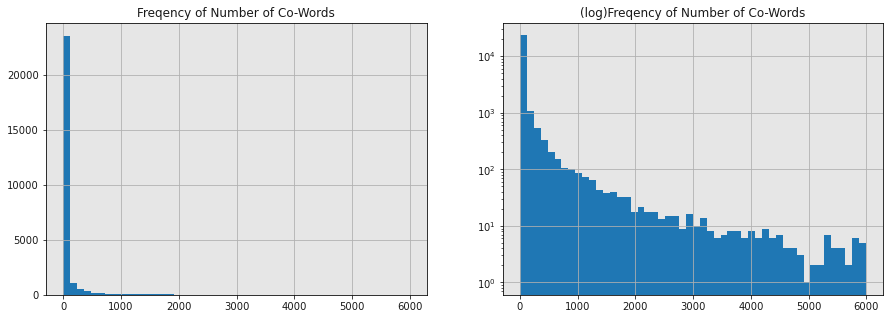

In [327]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)
# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')


In [53]:
# part c - spark job
def elem_comp(list1, list2):
    #Compare word by word and reduce array size as we go            
    overlap = 0
    go = True
    while go:
        word_frequent = list1[0]
        word_neighbor = list2[0]    

        if word_frequent == word_neighbor:
            overlap += 1
            list1.pop(0)
            list2.pop(0)
        elif word_frequent > word_neighbor:
            list2.pop(0)
        else:
            list1.pop(0)

        if len(list1) == 0 or len(list2) == 0:
            break

    return overlap


def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############


    tn_bn_length = rdd1.count()

        
    overlap = rdd1.join(rdd2).count()

    
    percent_overlap = overlap/tn_bn_length*100
    ############# (END) YOUR CODE ##############
    return percent_overlap



In [54]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
#most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)

total, topWords, bottomWords = EDA1(f1RDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(f1RDD, 1000)
# print(total)

twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 87.7 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 5.1 percent are also in the list of 1000 least frequent words.


In [674]:
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
# print(total)
start = time.time()
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print("Wall time: {} seconds".format(time.time() - start))
print()
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")


Wall time: 1.8512945175170898 seconds

Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words.


# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary'. Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) multiple choice:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?
<pre>  
  MULTIPLE CHOICE:
   A. 1000 most frequent words would overfit, while 1000 least frequent words would underfit
   B. 1000 most frequent words would underfit, while 1000 least frequent words would overfit
  
  BONUS: Explain your answer 
</pre>
* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary, what alternative strategy could we take?

* __c) multiple choice:__ Run the provided spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
<pre>
  What is another way to describe the Basis Vocabulary in machine learning terms?
  A. Stop-words
  B. Features
  C. Postings
  D. 1000-grams
</pre>

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:
> __a)__ Option B.

> __a-bonus)__  When keeping less frequent words, this will lead to increased variance which causes overfitting while keeping more common words leads to increased bias which will result in an underfit.

> __b)__ One could conduct random sampling to get an estimate of word frequency.    

> __c)__ B. Features.

In [67]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [56]:
# part c - get the vocabulary and basis (RUN THIS CELL AS IS)
# 
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############
    sw = sc.broadcast(set(STOPWORDS))
    top_10k = rdd.map(lambda line: line.split('\t')[0:2])\
                 .flatMap(lambda x: [(w, int(x[1])) for w in x[0].lower().split() 
                                     if w not in sw.value])\
                 .reduceByKey(lambda x,y: x+y)\
                 .takeOrdered(n_total, key=lambda x: -x[1])
    vocab = [pair[0] for pair in top_10k]
    basis = vocab[n_total - n_basis:]
    ############# (END) YOUR CODE ##############
    return vocab, basis

In [57]:
VOCAB_TEST, BASIS_TEST = get_vocab(testRDD, 10000, 1000)
print(VOCAB_TEST)
print(BASIS_TEST)

['times', 'age', 'worst', 'wisdom', 'best', 'foolishness']
[]


In [58]:
# part c - run your job (RUN THIS CELL AS IS)
start = time.time()
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 268.0176115036011 seconds

Wall time: 98.87772464752197 seconds


In [59]:
# part c - save to file (RUN THIS CELL AS IS)
with open("vocabulary.txt", "w") as file:
    file.write(str(VOCAB))
with open("basis.txt", "w") as file:
    file.write(str(BASIS))

In [83]:
# part d - spark job
#Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data 
# using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, 
# should return an RDD (which we will then use in q8).


def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############

    vocab_broad = sc.broadcast(set(vocab))
    basis_broad = sc.broadcast(set(basis))
    sw = sc.broadcast(set(STOPWORDS))


    def emitStripes(row):
        words = row.split(" ")
        for word in words:
            word = word.lower()
            if word not in vocab_broad.value:
                pass
            elif word in STOPWORDS:
                pass
            else:
                H = []
                for neighbor in words:
                    neighbor = neighbor.lower()
                    if neighbor == word or neighbor in sw.value or neighbor not in basis_broad.value:
                        pass
                    elif neighbor not in H:
                        H.append(neighbor)
                if len(set(H)) > 0:
                    yield (str(word), H)
    
    
    stripesRDD = rdd.map(lambda line: line.split('\t')[0]) \
                    .flatMap(emitStripes) \
                    .reduceByKey(lambda x,y: list(set(x+y))
                                 if (x is not None and y is not None) else 
                                 (x if x is not None else 
                                  (y if y is not None else
                                   ['']
                                  )
                                 )
                                ) 
    
    ############# (END) YOUR CODE ##############
    return stripesRDD

In [84]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
[print((i[0], set(i[1]))) for i in testStripesRDD.collect()]
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 0.1581110954284668 seconds
# Expected results
'''
[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]
'''

('best', {'times'})
('worst', {'times'})
('foolishness', {'age'})
('age', {'foolishness', 'wisdom', 'times'})
('wisdom', {'age'})
('times', {'worst', 'age', 'best'})
Wall time: 0.1641862392425537 seconds


"\n[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]\n"

In [85]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(f1RDD, 10000, 1000)
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS).cache()
start = time.time()
# print(f1StripesRDD.top(5))
[print((i[0], set(i[1]))) for i in f1StripesRDD.top(5)]
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.55739426612854 seconds
# Expected results
'''
[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
'''

('zippor', {'balak'})
('zedong', {'mao'})
('zeal', {'infallibility'})
('youth', {'constrained', 'mould'})
('younger', {'careers'})
Wall time: 1.4272127151489258 seconds


"\n[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]\n"

In [86]:
f1StripesRDD.saveAsTextFile(PWD + '/F1ddstripes')

In [87]:
# part d - run the full analysis and take a look at a few stripes (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 214.13801431655884 seconds
# Expected results:
'''
zones
['remotest', 'adhesion', 'residential', 'subdivided', 'environments', 'gaza', 'saturation', 'localities', 'uppermost', 'warmer', 'buffer', 'parks']
-------
zone
['tribal', 'narrower', 'fibrous', 'saturation', 'originate', 'auxiliary', 'ie', 'buffer', 'transitional', 'turbulent', 'vomiting', 'americas', 'articular', 'poorly', 'intervening', 'officially', 'accumulate', 'assisting', 'flexor', 'traversed', 'unusually', 'uppermost', 'cartilage', 'inorganic', 'illuminated', 'glowing', 'contamination', 'trigger', 'masculine', 'defines', 'avoidance', 'residential', 'southeastern', 'penis', 'cracks', 'atlas', 'excitation', 'persia', 'diffuse', 'subdivided', 'alaska', 'guides', 'au', 'sandy', 'penetrating', 'parked']
-------
zinc
['ammonium', 'coating', 'pancreas', 'insoluble', "alzheimer's", 'diamond', 'radioactive', 'metallic', 'weighing', 'dysfunction', 'wasting', 'phosphorus', 'transcription', 'dipped', 'hydroxide', 'burns', 'leukemia', 'dietary']
-------
'''

zones
['remotest', 'adhesion', 'residential', 'subdivided', 'environments', 'gaza', 'saturation', 'localities', 'uppermost', 'warmer', 'buffer', 'parks']
-------
zone
['tribal', 'narrower', 'fibrous', 'saturation', 'originate', 'auxiliary', 'ie', 'buffer', 'transitional', 'turbulent', 'vomiting', 'americas', 'articular', 'poorly', 'intervening', 'officially', 'accumulate', 'assisting', 'flexor', 'traversed', 'uppermost', 'unusually', 'cartilage', 'inorganic', 'illuminated', 'glowing', 'contamination', 'trigger', 'defines', 'masculine', 'avoidance', 'residential', 'cracks', 'penis', 'southeastern', 'atlas', 'excitation', 'diffuse', 'persia', 'subdivided', 'alaska', 'guides', 'au', 'sandy', 'penetrating', 'parked']
-------
zinc
['ammonium', 'coating', 'pancreas', 'insoluble', "alzheimer's", 'radioactive', 'diamond', 'metallic', 'weighing', 'dysfunction', 'wasting', 'phosphorus', 'transcription', 'dipped', 'hydroxide', 'burns', 'leukemia', 'dietary']
-------
Wall time: 150.24151611328125 

'\nzones\n[\'remotest\', \'adhesion\', \'residential\', \'subdivided\', \'environments\', \'gaza\', \'saturation\', \'localities\', \'uppermost\', \'warmer\', \'buffer\', \'parks\']\n-------\nzone\n[\'tribal\', \'narrower\', \'fibrous\', \'saturation\', \'originate\', \'auxiliary\', \'ie\', \'buffer\', \'transitional\', \'turbulent\', \'vomiting\', \'americas\', \'articular\', \'poorly\', \'intervening\', \'officially\', \'accumulate\', \'assisting\', \'flexor\', \'traversed\', \'unusually\', \'uppermost\', \'cartilage\', \'inorganic\', \'illuminated\', \'glowing\', \'contamination\', \'trigger\', \'masculine\', \'defines\', \'avoidance\', \'residential\', \'southeastern\', \'penis\', \'cracks\', \'atlas\', \'excitation\', \'persia\', \'diffuse\', \'subdivided\', \'alaska\', \'guides\', \'au\', \'sandy\', \'penetrating\', \'parked\']\n-------\nzinc\n[\'ammonium\', \'coating\', \'pancreas\', \'insoluble\', "alzheimer\'s", \'diamond\', \'radioactive\', \'metallic\', \'weighing\', \'dysfu

In [88]:
# part d - save your full stripes to file for ease of retrival later... (OPTIONAL)
stripesRDD.saveAsTextFile(PWD + '/stripes')

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

### Q8 Tasks:
* __a) short response:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation? (i.e. what are the features of our 1-hot encoded vectors?). What is the maximum length of a stripe?

* __b) short response:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.' How many rows will there be in our inverted index? Explain.

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index?

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` _(key:term, value:posting)_   
  * aggregates the postings to create an inverted index _(key:term, value:list of postings)_
  * loops over all pairs of `term`s that appear in the same postings list and emits co-occurrence counts
  * aggregates co-occurrences _(key:word pair, value:count + other payload)_
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also return the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:
> __a)__ The maximum length of a stripe is the length of a given document minus one (i.e. the key word) if the document did not contain any stop words and only contained words that basis text file.  

> __b)__ The inverted index will contain a row for each key as the inverted index is formed by aggregating the individual term-postings into a flattened key-list of postings.  

> __c)__ The inverted index is a useful technique for capturing info that can directly be fed into a reducer by key. The vector form in question 2 needs the entire vocabulary to calculate the similairity. For a sparse vector like cooccurence matrices, this is a computationally and storage intensive process.  

> __e)__ several of the same words appear multiple times and are common compound phrases/adjetive noun pairs e.g. first-time = first time, great-time = great time, made-well = well made. To improve the quality of analysis, a list of compound phrases can be used to transform these sepearte words as one word phrase.

In [89]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```

In [433]:
# part d - write your spark job in the space provided
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None

    # Math helper functions for computing similarity scores
    def sqrt(x):
        return x**0.5
    
    def cosine_q8(line):
        """Mapper: compute cosine similarity scores"""
        (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
        total = int(line[1])
        cosine = total / float(sqrt(int(n1))*sqrt(int(n2)))
        yield doc1+" - "+doc2, cosine
    
    def jaccard_q8(line):
        """Mapper: compute jaccard similarity scores"""
        (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
        total = int(line[1])
        jaccard = total / float(int(n1) + int(n2) - total)
        yield doc1+" - "+doc2, jaccard
        
    def overlap_q8(line):
        """Mapper: compute overlap similarity scores"""
        (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
        total = int(line[1])
        overlap = total / float(min([int(n1), int(n2)]))
        yield doc1+" - "+doc2, overlap

    def dice_q8(line):
        """Mapper: compute dice similarity scores"""
        (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
        total = int(line[1])
        dice = 2*total / float(int(n1) + int(n2))
        yield doc1+" - "+doc2, dice
    
#pairs map-reduce pipeline  
#     result = data.map(lambda line: line.split('\t')) \
#              .flatMap(splitWords) \
#              .reduceByKey(lambda x,y : x+y) \
#              .flatMap(makeCompositeKey) \
#              .reduceByKey(lambda x,y : x+y) \
#              .flatMap(jaccard) \
#              .takeOrdered(10, key=lambda x: -x[1])
    
    def emitStripes_counts(row):
        """Get the key and stripe words
        Expected Input Format: [(('age', 3), {'wisdom': 1, 'foolishness': 1, 'times': 1})...
        Expected Output Format: [(('age', 3), {'wisdom': 1, 'foolishness': 1, 'times': 1}),
                                 (('best', 1), {'times': 1})..."""
        key = row[0]
        words = row[1]
        
        #create a posting dictionary with the neighbor counts
        H = {}
        for neighbor in words:    
            if neighbor == key:
                pass
            elif neighbor not in H.keys():
                H[neighbor] = 1
            else:
                H[neighbor] = H[neighbor] + 1
        yield ((str(key), len(H)), H) #emit word-strip length as key and cooccurence dict as counts
  
    # Flat Map (Split Words):
    def split_words(row):
        """Provides a list of postings (i.e. inverted index) where the keys are the non-unique words and 
        the values are the values are tupple with the document ID and the words in that document ID (i.e. inverted index)
        Expected Input Format: 
            [(('age', 3), {'wisdom': 1, 'foolishness': 1, 'times': 1}),
            (('best', 1), {'times': 1})...
        Expected Output Format Output:
            [('wisdom', [('ages', 3)]),
            ('foolishness', [('ages', 3)])..."""
        docid = row[0]
        posting_list = row[1]
        for key, value in posting_list.items():
            yield (key, docid)

    # Reduce By Key:
    def reduce_split_words(row1, row2):
        """Aggregates the keys such that the values now are a list of tuples with doc IDS and doc lengs 
        Expected Input Format:
            [('wisdom', [('ages', 3)]),
            ('foolishness', [('ages', 3)])...
        Expected Output Format:
            ([('ages', 3), ('best', 1), ('times', 1)]"""
        
        if row1 is None and row2 is None:
            pass
        elif row1 is None:
            row2 = [row2]
            return row2
        elif row2 is None:
            row1 = [row1]
            return row1
        else:
            if type(row1) is list and type(row2) is list:
                return row1 + row2
            elif type(row1) is list:
                return row1 + [row2]
            elif type(row2) is list:
                return [row1] + row2
            else:
                return [row1] + [row2]
    
    # Flat Map(makeCompositeKey):
    # Make a table with the number of co occurences between doc IDS with counters of 1
    def makeCompositeKey(inverted_index):
        """Loop over postings and yield pairs.
        Expected Input Format:
            ([('ages', 3), ('best', 1), ('times', 1)]
        Expected Output Format:
            [("(('docA', 4), ('docB', 4))", 1),
            ("(('docA', 4), ('docC', 4))", 1),"""
        
        word, postings = inverted_index
        # taking advantage of symmetry, output only (a,b), but not (b,a)
        try:
            for subset in itertools.combinations(sorted(postings), 2):
                yield (str(subset), 1)
        except:
            pass
          
    # Reduce By Key():
    # Aggregate the table so the counters are aggregated
    # [("(('docA', 4), ('docB', 4))", 2),
    cooccurence_matrix = stripesRDD.flatMap(emitStripes_counts) \
                        .flatMap(split_words) \
                        .reduceByKey(reduce_split_words) \
                        .flatMap(makeCompositeKey) \
                        .reduceByKey(lambda x,y: x + y)
    
    # Flat Map:
    # Calculate the  Similartiy scores for each unique Doc ID pair
    # cosine, jaccard, dice and overlap
    cosine_result = cooccurence_matrix.flatMap(cosine_q8)
    jaccard_result = cooccurence_matrix.flatMap(jaccard_q8)
    overlap_result = cooccurence_matrix.flatMap(overlap_q8)
    dice_result = cooccurence_matrix.flatMap(dice_q8)
    
    # Joine the results
    result = cosine_result.join(jaccard_result) \
                .join(overlap_result) \
                .map(lambda x: (x[0], (x[1][0][0], x[1][0][1], x[1][1]))) \
                .join(dice_result) \
                .map(lambda x: (x[0], (x[1][0][0], x[1][0][1], x[1][0][2], x[1][1]))) \

    
    # Sort based on Cosine Similarity
    top_n = result.takeOrdered(n, key=lambda x: -x[1][0])
    bottom_n = result.takeOrdered(n, key=lambda x: x[1][0])
    
    
    return result, top_n, bottom_n

In [434]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.4768586158752441 seconds

Wall time: 1.857896327972412 seconds


In [435]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.9845571517944336 seconds

Wall time: 3.801274299621582 seconds


In [436]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
employment - partly      |   1.0,     1.0,     1.0,   1.0
reward - splendour       |   1.0,     1.0,     1.0,   1.0
papers - removed         |   1.0,     1.0,     1.0,   1.0
intensity - realization  |   1.0,     1.0,     1.0,   1.0
friendship - intimate    |   1.0,     1.0,     1.0,   1.0
federation - player      |   1.0,     1.0,     1.0,   1.0
federation - playing     |   1.0,     1.0,     1.0,   1.0
player - playing         |   1.0,     1.0,     1.0,   1.0
allowing - apparently    |   1.0,     1.0,     1.0,   1.0
achieved - court's       |   1.0,     1.0,     1.0,   1.0


In [ ]:
#Lucas note to grader: in the "f1dd_CosJacOverDice.txt", I calculated the following similarity scores:
# ('commentary - lady', (1.0, 1.0, 1.0, 1.0))
# ('commentary - reply', (1.0, 1.0, 1.0, 1.0))
# ('commentary - toes', (1.0, 1.0, 1.0, 1.0))
# ('curious - lady', (1.0, 1.0, 1.0, 1.0))
# ('curious - owe', (1.0, 1.0, 1.0, 1.0))
# ('curious - tone', (1.0, 1.0, 1.0, 1.0))
# ('lady - reply', (1.0, 1.0, 1.0, 1.0))
# ('lady - toes', (1.0, 1.0, 1.0, 1.0))
# ('lady - tone', (1.0, 1.0, 1.0, 1.0))
# ('reply - tone', (1.0, 1.0, 1.0, 1.0))


In [437]:
displayOutput(bottom_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
little - part            |0.0355,  0.0179,  0.0417, 0.0351
part - us                |0.0355,  0.0179,  0.0417, 0.0351
made - upon              |0.0357,  0.0182,   0.037, 0.0357
made - two               |0.0357,  0.0182,   0.037, 0.0357


In [438]:
with open("f1dd_CosJacOverDice.txt", "w") as file:
    f1ResultsSorted = f1Result.collect()
    f1ResultsSorted.sort()
    [file.write(str(i) + "\n") for i in f1ResultsSorted]

In [439]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1851.9786894321442 seconds

Wall time: 1487.0970714092255 seconds


In [440]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433

In [441]:
displayOutput(bottom_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068


__Expected output f1RDD:__  
<table>
<th>MOST SIMILAR:</th>
<th>LEAST SIMILAR:</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
commentary - lady        |   1.0,     1.0,     1.0,   1.0
commentary - toes        |   1.0,     1.0,     1.0,   1.0
commentary - reply       |   1.0,     1.0,     1.0,   1.0
curious - tone           |   1.0,     1.0,     1.0,   1.0
curious - lady           |   1.0,     1.0,     1.0,   1.0
curious - owe            |   1.0,     1.0,     1.0,   1.0
lady - tone              |   1.0,     1.0,     1.0,   1.0
reply - tone             |   1.0,     1.0,     1.0,   1.0
lady - toes              |   1.0,     1.0,     1.0,   1.0
lady - reply             |   1.0,     1.0,     1.0,   1.0
</pre></td>
<td><pre>

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
part - us                |0.0355,  0.0179,  0.0417, 0.0351
little - part            |0.0355,  0.0179,  0.0417, 0.0351
made - two               |0.0357,  0.0182,   0.037, 0.0357
made - upon              |0.0357,  0.0182,   0.037, 0.0357
</pre></td></tr>
</table>

__Expected output dataRDD:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433
new - time               |0.8426,   0.724,  0.9133, 0.8399
first - two              |0.8411,  0.7249,  0.8737, 0.8405
way - well               |0.8357,  0.7146,  0.8986, 0.8335
time - us                |0.8357,  0.7105,  0.9318, 0.8308

</pre></td>
<td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential      |0.0081,   0.004,  0.0093, 0.008
desert - function        |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood      |0.0081,  0.0038,  0.0115, 0.0077
patients - plain         |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

### Congratulations, you have completed HW3! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform